<a href="https://colab.research.google.com/github/Mainakdeb/elegant-embryos/blob/main/compare_cell_population_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Latest Version of Scikit-Learn

In [9]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


## Clone the Devolearn Repository to Access Current Models

In [14]:
!bash

bash: cannot set terminal process group (59): Inappropriate ioctl for device
bash: no job control in this shell
/content# !git clone https://github.com/DevoLearn/devolearn.git
bash: !git: event not found
/content# git clone https://github.com/DevoLearn/devolearn.git
fatal: destination path 'devolearn' already exists and is not an empty directory.
/content# cd devolearn
/content/devolearn# git reset --hard 61eb88dbfb1278c6f5fae2843f6e1eb37f1b551a
HEAD is now at 61eb88d readme : add links to datasets (#37)
/content/devolearn# exit
exit


## Copy Datasets from Google Drive

In [ ]:
!cp /content/drive/MyDrive/mydata/epic_subsets/epic_10k.csv /content/
!cp /content/drive/MyDrive/mydata/epic_subsets/scaled_epic_10k.csv /content/
!cp /content/drive/"My Drive"/frames_raw.zip /content/
!unzip frames_raw.zip

## Copy Upgraded Model and Scaler from Google Drive

In [16]:
!cp /content/drive/MyDrive/models/lineage_pop_res_50/10k_res_18_identical_2.pth /content/
!cp /content/drive/MyDrive/mydata/scalers/scaler_new_10k.gz /content/

cp: cannot stat '/content/drive/MyDrive/models/lineage_pop_res_50/10k_res_18_identical_2.pth': No such file or directory


In [17]:
import torch
import torchvision.models as models
import torch.nn as nn
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

## Set `device` as Cuda (GPU) for Faster Inference.

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Define and Load Model(s)
* Architecture: ResNet18 with custom linear layers.



In [19]:
model_dummy = models.resnet18(pretrained = True)
model_1 = models.resnet18(pretrained = True)
model_2 = models.resnet18(pretrained = True)
model_1.fc = model_1.fc = nn.Linear(512, 7)
model_2.fc = model_2.fc = nn.Linear(512, 7)
model_dummy.fc = model_dummy.fc = nn.Linear(512, 7)

model_1 = model_1.to(device)
model_2 = model_2.to(device)
model_dummy=model_dummy.to(device)

## Loading `model_1` and `scaler_1`
* `model_1` uses weights from the cloned devolearn repository, in order to emulate performance of the devolearn library.
* To ensure even data scaling, I'm also loading up the scaler from devolearn's repository as `scaler_1`

In [22]:
model_1.load_state_dict(torch.load("/content/devolearn/devolearn/lineage_population_model/estimate_lineage_population.pt"))
scaler_1 = joblib.load("/content/devolearn/devolearn/lineage_population_model/scaler/scaler.gz")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Loading `model_1` and `scaler_1`
* `model_1` uses weights from the cloned devolearn repository, in order to emulate performance of the devolearn library.
* To ensure even data scaling, I'm also loading up the scaler from devolearn's repository as `scaler_1`

In [24]:
model_2.load_state_dict(torch.load("/content/drive/MyDrive/models/devolearn/estimate_lineage_population.pth"))
scaler_2 = joblib.load("/content/scaler_new_10k.gz")

## Set Models to `eval()` mode
model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. You need to turn off them during model evaluation, and .eval() will do it for you. [source](https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch#:~:text=answer%20was%20accepted%E2%80%A6-,model.,will%20do%20it%20for%20you.)

In [ ]:
model_1.eval()
model_2.eval()

## Plot data distributions:

Minimun values of each column (devolearn) =  [0. 0. 0. 0. 0. 0. 0.]
Maximum values of each column (devolearn) =  [250.  14.  43.   1.  26.   8.   2.]
Minimun values of each column (new) =  [0. 0. 0. 0. 0. 0. 0.]
Maximum values of each column (new) =  [250.  16.  78.   1.  31.  16.   2.]


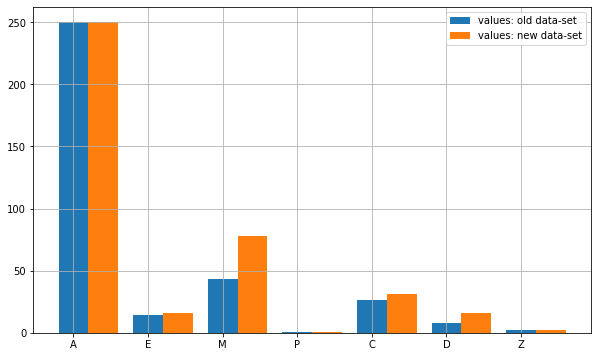

In [26]:
print("Minimun values of each column (devolearn) = ", scaler_1.data_min_)
print("Maximum values of each column (devolearn) = ", scaler_1.data_max_)
print("Minimun values of each column (new) = ", scaler_2.data_min_)
print("Maximum values of each column (new) = ", scaler_2.data_max_)

plt.rcParams['figure.figsize'] =10, 6
width = 0.40
labels=['A','E','M', 'P', 'C', "D", "Z"]
ind = np.arange(7)
plt.bar(ind, scaler_1.data_max_, width, label="values: old data-set")
plt.bar(ind+width, scaler_2.data_max_, width,  label="values: new data-set")
plt.xticks(ind, labels)
plt.grid()
plt.legend(loc='best')
plt.show()

## Define transforms:

In [27]:
mini_transform = transforms.Compose([
                                     transforms.ToPILImage(),
                                      transforms.Resize((256,256), interpolation = Image.NEAREST),
                                     transforms.ToTensor(),
                                     transforms.Normalize(0.5, 0.5, 0.5)
])

## Define `researcher_vs_model()`:
Runs inference on frames single video tag using a defined model and scaler, then plots a graph showcasing the predictions and labels.

Args:
* look_for_tag = string containing video id.
* model_ = model for running inference.
* scaler_ = contains data scaling attributes for even scaling and unscaling of attributes.

In [28]:
def researcher_vs_model(look_for_tag, model_, scaler_):
    df_test = pd.read_csv("scaled_epic_10k.csv")
    df_single_cell = df_test[df_test['filenames'].str.contains(look_for_tag)]
    a_pop_upper_limit = 250
    df_test = df_test[df_test["A"] <= a_pop_upper_limit]
    data = scaler_.inverse_transform(df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values)
    real_time_plots = []
    
    for i in range(len(df_single_cell.columns[1:])):
        real_time_plots.append(data[:,i])

    preds = []
    filenames = df_single_cell.filenames.values

    for i in range (len(filenames)):
        image = cv2.imread(filenames[i])
        tensor = mini_transform(image).unsqueeze(0).to(device)
        pred = model_(tensor).cpu().detach().numpy().flatten()
        preds.append(pred)
        
    preds = scaler_.inverse_transform(np.array(preds)).astype(np.uint8)

    generated_time_plots = []
    for i in range(len(df_single_cell.columns[1:])):
        generated_time_plots.append(preds[:,i])

    plt.rcParams['figure.figsize'] =25, 10

    for i in range(len(real_time_plots)):
        plt.plot(real_time_plots[i], label = df_single_cell.columns[:-1][i] )

    for i in range(len(generated_time_plots)):
        plt.plot(generated_time_plots[i], label = df_single_cell.columns[:-1][i] + "_pred", linestyle = "--", linewidth = 2 )

    plt.xlabel("time", fontsize = 25)
    plt.ylabel("population", fontsize = 25)
    plt.legend(fontsize = 20)
    plt.grid()
    plt.show()

## Run inference on video (tag 20080709_ceh-27_1_L1) -  using model_1 (Devolearn)

* dotted lines = predicted values
* non dotted lines = labels



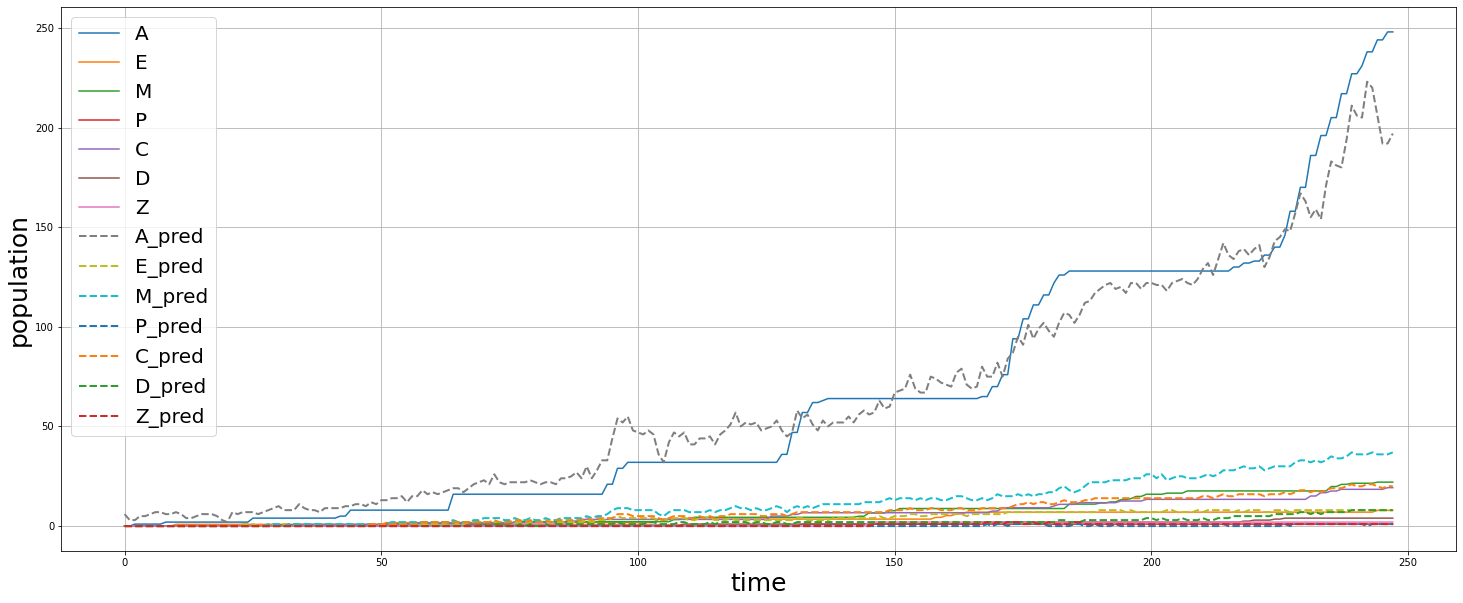

In [29]:
researcher_vs_model(look_for_tag="20080709_ceh-27_1_L1", 
                    model_ = model_1, 
                    scaler_=scaler_1)

## Run inference on video (tag 20080709_ceh-27_1_L1) - using model_2 (upgraded)

* dotted lines = predicted values
* non dotted lines = labels


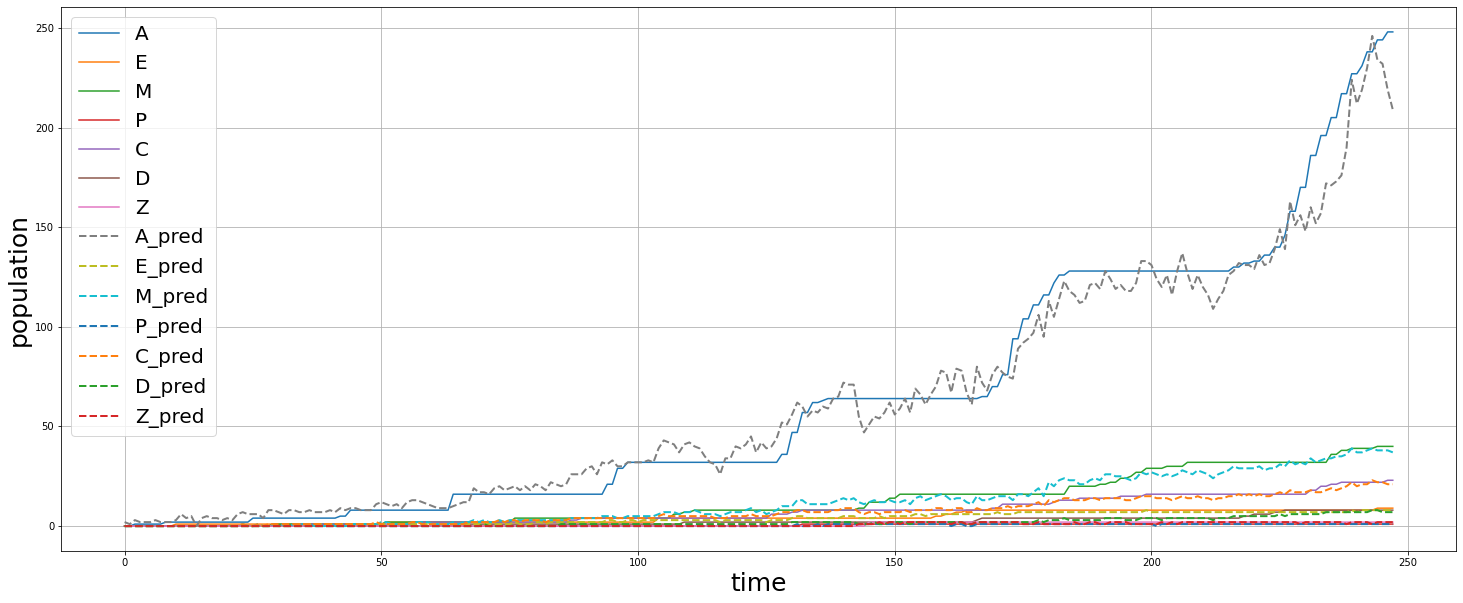

In [30]:
researcher_vs_model(look_for_tag="20080709_ceh-27_1_L1", 
                    model_ = model_2, 
                    scaler_=scaler_2)

## Define `compute_loss()`:
This function runs inference on a single video, using a defined model and its corresponding scaler, and returns the loss. This loss metric basically represents how accurate the predictions are. Less loss is better.

Args:
* look_for_tag = string containing video id.
* model_ = model for running inference.
* scaler_ = contains data scaling attributes for even scaling and unscaling of attributes. 

In [31]:
from sklearn.metrics import mean_squared_error

def compute_loss(look_for_tag, model_, scaler_):
  df_test = pd.read_csv("scaled_epic_10k.csv")
  df_single_cell = df_test[df_test['filenames'].str.contains(look_for_tag)]
  a_pop_upper_limit = 250
  df_test = df_test[df_test["A"] <= a_pop_upper_limit]
  data = scaler_.inverse_transform(df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values)
  data_unscaled=df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values
  real_time_plots = []
  
  for i in range(len(df_single_cell.columns[1:])):
      real_time_plots.append(data_unscaled[:,i])

  preds = []
  filenames = df_single_cell.filenames.values

  for i in range (len(filenames)):
      image = cv2.imread(filenames[i])
      tensor = mini_transform(image).unsqueeze(0).to(device)
      pred = model_(tensor).cpu().detach().numpy().flatten()
      preds.append(pred)
      
  #preds = scaler_.inverse_transform(np.array(preds)).astype(np.uint8)
  preds = np.array(preds).astype(np.uint8)
  generated_time_plots = []
  
  for i in range(len(df_single_cell.columns[1:])):
      generated_time_plots.append(preds[:,i])

  loss = mean_squared_error(real_time_plots,generated_time_plots)
  return(loss)

In [32]:

print("\nloss in video id: "+"20080709_ceh-27_1_L1"+" using model_1 (devolearn)=", compute_loss(look_for_tag="20080709_ceh-27_1_L1", 
                                              model_=model_1, 
                                              scaler_=scaler_1))

print("loss in video id: "+"20080709_ceh-27_1_L1"+"using model_2 (upgraded)=", compute_loss(look_for_tag="20080709_ceh-27_1_L1", 
                                              model_=model_2, 
                                              scaler_=scaler_2))


loss in video id: 20080709_ceh-27_1_L1 using model_1 (devolearn)= 0.16264253017743988
loss in video id: 20080709_ceh-27_1_L1using model_2 (upgraded)= 0.0848775532189145


## Creating a longer list of video tags for further testing:

In [33]:
df = pd.read_csv("/content/scaled_epic_10k.csv")
df = pd.DataFrame(df.filenames.str.split('/',1).tolist(),
                                 columns = ['dir','filenames'])
df = pd.DataFrame(df.filenames.str.split('/',1).tolist(),
                                 columns = ['vid_id','frame'])

all_tags=list(df.vid_id.unique())

## Compute losses on 36 videos, using 2 different models.

In [34]:
video_losses_1=[]
video_losses_2=[]
for tag in all_tags:
  loss_1=compute_loss(look_for_tag=tag, 
                      model_=model_1, 
                      scaler_=scaler_1)
  loss_2=compute_loss(look_for_tag=tag, 
                      model_=model_2, 
                      scaler_=scaler_2)
  video_losses_1.append(loss_1)
  video_losses_2.append(loss_2)

## Plot loss values derived from all 36 videos, for 2 models:
* Red bar(s) = devolearn
* Green bar(s) = upgraded model

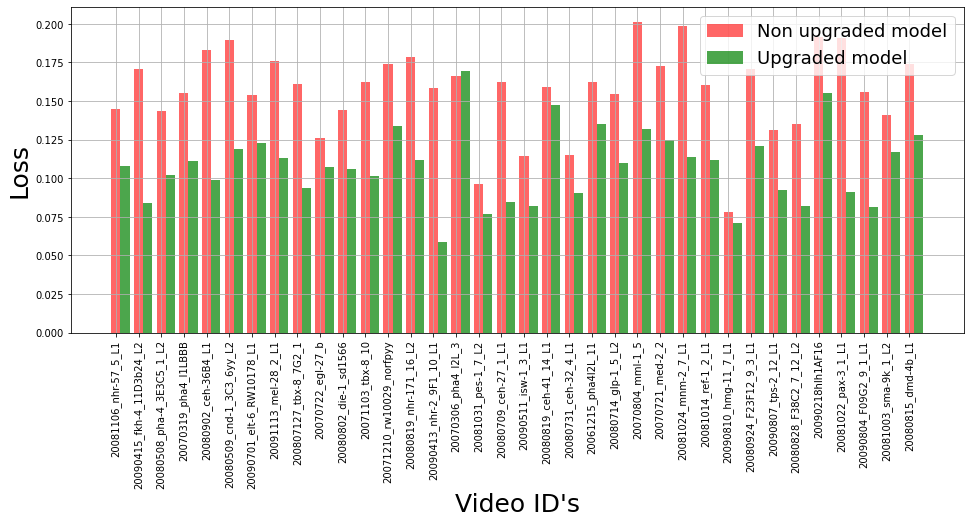

In [55]:
plt.rcParams['figure.figsize'] =16, 6
#plt.rcParams.update(plt.rcParamsDefault)

width = 0.40
labels=all_tags
ind = np.arange(36)
plt.bar(ind, video_losses_1, width, label="Non upgraded model", color='red', alpha=0.6)
plt.bar(ind+width, video_losses_2, width,  label="Upgraded model", color ='green', alpha=0.7)
plt.xticks(ind, labels, rotation='vertical')
plt.ylabel('Loss', fontsize=25)
plt.xlabel("Video ID's", fontsize=25)
plt.grid()
plt.legend(loc='best', fontsize=18)
plt.show()

## Plot the average loss on all videos, for 2 models:


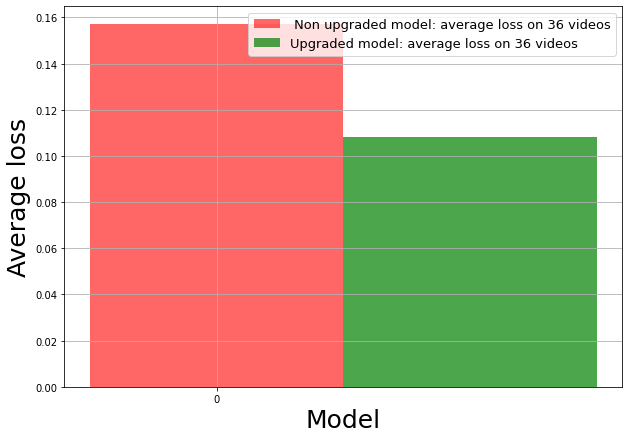

In [52]:
plt.rcParams['figure.figsize'] =10, 7

average_video_losses_1=np.mean(video_losses_1)
average_video_losses_2=np.mean(video_losses_2)
width = 0.10
labels=all_tags
ind = np.arange(1)
plt.bar(ind, average_video_losses_1, width, label=" Non upgraded model: average loss on 36 videos", color='red', alpha=0.6)
plt.bar(ind+width, average_video_losses_2, width,  label="Upgraded model: average loss on 36 videos", color='green', alpha=0.7)
plt.xticks(ind)
plt.ylabel('Average loss', fontsize=25)
plt.xlabel("Model", fontsize=25)
plt.grid()
plt.legend(loc='best', fontsize=13)
plt.show()